In [2]:
import numpy as np
import MyML.EAC.full as myEacFull
import MyML.EAC.sparse as myEacSp
import MyML.EAC.eac as myEac
import MyML.EAC.eac_new as myNewEac
import MyML.cluster.K_Means3 as myKM
import MyML.helper.partition as myEacPart
import MyML.metrics.accuracy as myAcc

import matplotlib.pyplot as plt
%matplotlib inline

/home/chiroptera/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:106: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [2]:
reload(myEacFull)
reload(myEacPart)
reload(myEacSp)
reload(myEac)
reload(myNewEac)

<module 'MyML.EAC.eac_new' from '/home/chiroptera/workspace/QCThesis/MyML/EAC/eac_new.pyc'>

In [3]:
# rules for picking kmin kmax 
def rule1(n):
    """sqrt"""
    k = [np.sqrt(n)/2, np.sqrt(n)]
    k = map(np.ceil,k)
    k = map(int, k)
    return k

def rule2(n):
    """2sqrt"""
    k =  map(lambda x:x*2,rule1(n))
    return k

def rule3(n, sk, th):
    """fixed s/k"""
    k = [n * 1.0 / sk, th * n * 1.0 / sk]
    k = map(np.ceil,k)
    k = map(int, k)
    return k

def rule4(n):
    """sk=sqrt/2,th=30%"""
    return rule3(n, sk1(n), 1.3)

def rule5(n):
    """sk=300,th=30%"""
    return rule3(n,300, 1.3)

# rules for picking number of samples per cluster
def sk1(n):
    """sqrt/2"""
    return int(np.sqrt(n) / 2)

CPU times: user 857 µs, sys: 0 ns, total: 857 µs
Wall time: 868 µs
CPU times: user 3min 7s, sys: 20.1 s, total: 3min 27s
Wall time: 3min 28s


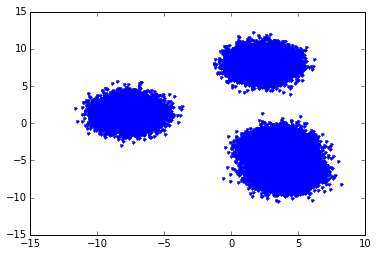

In [4]:
from sklearn.datasets import make_blobs

n_samples = 100000
data,gt = make_blobs(n_samples, centers=4)
%time data = data.astype(np.float32)
n_clusts = rule4(n_samples)

plt.plot(data[:,0], data[:,1], '.')

generator = myKM.K_Means()
generator._MAX_THREADS_BLOCK = 256
%time ensemble = myEacPart.generateEnsemble(data, generator, n_clusts,npartitions=100)

In [7]:
myEacSp._compute_max_assocs_from_ensemble(ensemble)*3

1422

In [8]:
%time fullEAC = myNewEac.EAC(n_samples, sparse=True, condensed=False, sparse_keep_degree=True)
fullEAC.sp_max_assocs_mode = "constant"
%time fullEAC.buildMatrix(ensemble)

%time spEAC = myNewEac.EAC(n_samples, sparse=True, condensed=True, sparse_keep_degree=True)
spEAC.sp_max_assocs_mode = "constant"
%time spEAC.buildMatrix(ensemble)

CPU times: user 30 µs, sys: 3 µs, total: 33 µs
Wall time: 45.1 µs
CPU times: user 3min 34s, sys: 1 s, total: 3min 35s
Wall time: 3min 36s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26 µs
CPU times: user 1min 48s, sys: 718 ms, total: 1min 49s
Wall time: 2min 5s


In [11]:
import seaborn as sns
sns.set_style("darkgrid")

/home/chiroptera/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [12]:
sns.set_palette(sns.color_palette("deep", 6))

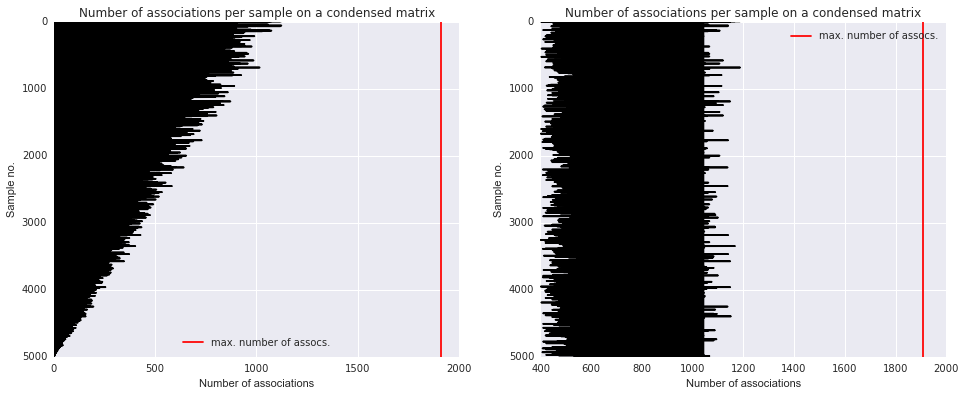

In [43]:
fig1 = plt.figure(figsize=(16,6))

ax = fig1.add_subplot(1,2,1)
x = np.arange(n_samples)
y = spEAC.coassoc.degree[:-1]

ax.plot(y,x, 'k', alpha=1)
ax.fill_between(y,0,x,color='k', alpha=1)
ax.plot([spEAC.sp_max_assocs, spEAC.sp_max_assocs], [0, n_samples], 'r', label="max. number of assocs.")
ax.set_title("Number of associations per sample on a condensed matrix")
ax.set_ylabel("Sample no.")
ax.set_xlabel("Number of associations")
plt.gca().invert_yaxis()
ax.legend(loc="best")

ax = fig1.add_subplot(1,2,2)
x = np.arange(n_samples)
y = fullEAC.coassoc.degree[:-1]

ax.plot(y,x, 'k', alpha=1)
ax.fill_between(y,0,x,color='k', alpha=1)
ax.plot([spEAC.sp_max_assocs, spEAC.sp_max_assocs], [0, n_samples], 'r', label="max. number of assocs.")
ax.set_title("Number of associations per sample on a condensed matrix")
ax.set_ylabel("Sample no.")
ax.set_xlabel("Number of associations")
plt.gca().invert_yaxis()
ax.legend(loc="best")

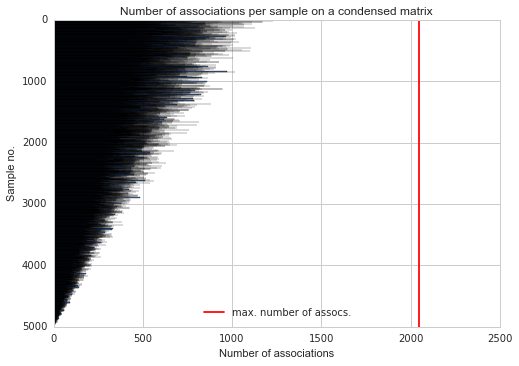

In [45]:
fig_cond = plt.figure()
x = np.arange(n_samples)
y = spEAC.coassoc.degree[:-1]

plt.barh(x, y)
plt.plot([spEAC.sp_max_assocs, spEAC.sp_max_assocs], [0, n_samples], 'r', label="max. number of assocs.")
plt.title("Number of associations per sample on a condensed matrix")
plt.ylabel("Sample no.")
plt.xlabel("Number of associations")
plt.gca().invert_yaxis()
plt.legend(loc="best")

In [13]:
from MyML.helper.plotting import save_fig

In [47]:
save_fig(fig_cond, "/home/chiroptera/eac_csr_cond_degree")
save_fig(fig_full, "/home/chiroptera/eac_csr_full_degree")

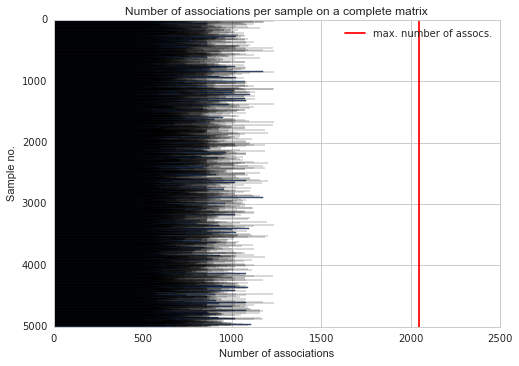

In [46]:
fig_full = plt.figure()
x = np.arange(n_samples)
y = fullEAC.coassoc.degree[:-1]

plt.barh(x, y)
plt.plot([spEAC.sp_max_assocs, spEAC.sp_max_assocs], [0, n_samples], 'r', label="max. number of assocs.")
plt.title("Number of associations per sample on a complete matrix")
plt.ylabel("Sample no.")
plt.xlabel("Number of associations")
plt.gca().invert_yaxis()
plt.legend(loc="best")

In [7]:
%time fullEAC.finalClustering(n_clusters=0) 
%time spEAC.finalClustering(n_clusters=0)
# b MyML/EAC/eac_new.py:606
# b MyML/EAC/eac_new.py:556

CPU times: user 419 ms, sys: 0 ns, total: 419 ms
Wall time: 419 ms
CPU times: user 300 ms, sys: 12 ms, total: 312 ms
Wall time: 311 ms


array([0, 1, 2, ..., 3, 3, 2], dtype=int32)

full bincount [1250 1250 2500]
full bincount [1250 2500 1250]


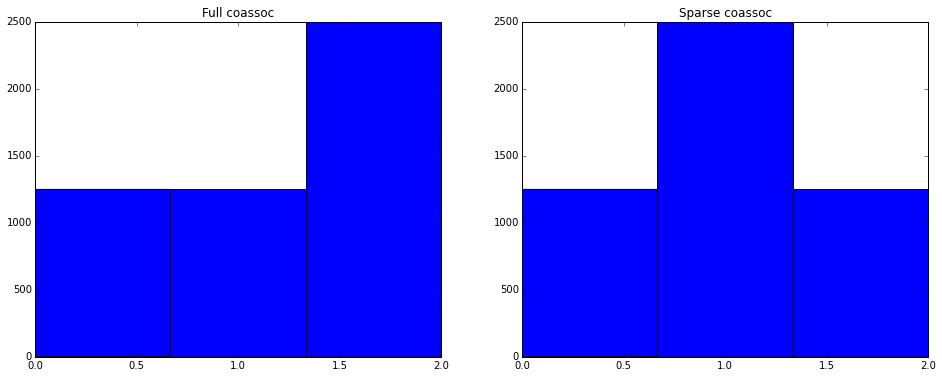

In [100]:
histFig = plt.figure(figsize=(16,6))

ax = histFig.add_subplot(1,2,1)
ax.hist(fullEAC.labels,bins=fullEAC.n_fclusts)
ax.set_title("Full coassoc")
print "full bincount", np.bincount(fullEAC.labels)

ax = histFig.add_subplot(1,2,2)
ax.hist(spEAC.labels,bins=spEAC.n_fclusts)
ax.set_title("Sparse coassoc")
print "full bincount", np.bincount(spEAC.labels)

In [101]:
acc = myAcc.HungarianIndex(n_samples)
acc.score(gt, fullEAC.labels)
acc.accuracy

0.75

In [102]:
acc = myAcc.HungarianIndex(n_samples)
acc.score(gt, spEAC.labels)
acc.accuracy

0.0

In [103]:
acc2 = myAcc.ConsistencyIndex(N=n_samples)
acc2.score(gt, fullEAC.labels)

0.75

In [104]:
acc2 = myAcc.ConsistencyIndex(N=n_samples)
acc2.score(gt, spEAC.labels)

0.75

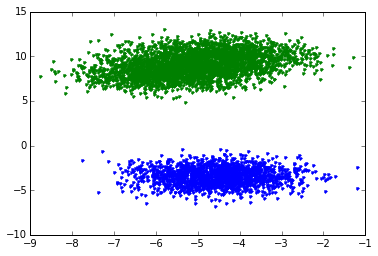

In [36]:
for c in xrange(fullEAC.n_fclusts):
    c_idx = fullEAC.labels == c
    plt.plot(data[c_idx,0], data[c_idx,1], '.')

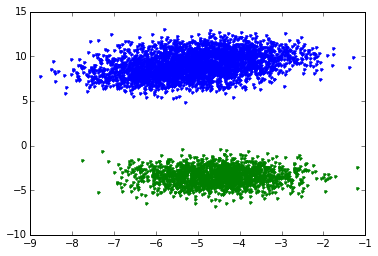

In [37]:
for c in xrange(spEAC.n_fclusts):
    c_idx = spEAC.labels == c
    plt.plot(data[c_idx,0], data[c_idx,1], '.')

In [20]:
(fullEAC.coassoc.todense() == (spEAC.coassoc.todense() + spEAC.coassoc.todense().T)).all()

True

In [14]:
%time full = myEacFull.EAC_FULL(n_samples, condensed=False)
%time full.update_ensemble(ensemble)

CPU times: user 1.57 ms, sys: 70 µs, total: 1.64 ms
Wall time: 872 µs
CPU times: user 274 ms, sys: 3.84 ms, total: 278 ms
Wall time: 279 ms


In [15]:
%time cfull = myEacFull.EAC_FULL(n_samples, condensed=True)
%time cfull.update_ensemble(ensemble)

CPU times: user 683 µs, sys: 30 µs, total: 713 µs
Wall time: 472 µs
CPU times: user 69.2 ms, sys: 23 µs, total: 69.2 ms
Wall time: 67.1 ms


In [16]:
(full.coassoc == cfull.todense() + ).all()

True

In [17]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time sp = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=False, sort_mode="numpy")
%time sp.update_ensemble(ensemble)

CPU times: user 141 µs, sys: 6 µs, total: 147 µs
Wall time: 131 µs
CPU times: user 3.28 s, sys: 11.3 ms, total: 3.29 s
Wall time: 3.28 s


In [18]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time sp2 = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=False, sort_mode="surgical")
%time sp2.update_ensemble(ensemble)

CPU times: user 146 µs, sys: 6 µs, total: 152 µs
Wall time: 136 µs
CPU times: user 1.24 s, sys: 16.2 ms, total: 1.26 s
Wall time: 1.24 s


In [21]:
sp._condense(keep_degree=True)
sp2._condense(keep_degree=True)
print (sp.todense() == sp2.todense()).all()
print (sp.todense() == full.coassoc).all()

True
True


In [22]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=True, sort_mode="numpy")
%time csp.update_ensemble(ensemble)

CPU times: user 269 µs, sys: 10 µs, total: 279 µs
Wall time: 223 µs
CPU times: user 2.31 s, sys: 3.76 ms, total: 2.31 s
Wall time: 2.3 s


In [23]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp2 = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=True, sort_mode="surgical")
%time csp2.update_ensemble(ensemble)

CPU times: user 140 µs, sys: 4 µs, total: 144 µs
Wall time: 131 µs
CPU times: user 513 ms, sys: 8.18 ms, total: 521 ms
Wall time: 510 ms


In [24]:
csp._condense(keep_degree=True)
csp2._condense(keep_degree=True)

print "condensed numpy", ((csp.todense() + csp.todense().T) == full.coassoc).all()
print "condensed surgical", ((csp2.todense() + csp2.todense().T) == full.coassoc).all()

condensed numpy True
condensed surgical True


In [25]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp2 = myEacSp.EAC_CSR(n_samples, max_assocs, max_assocs_type='linear', condensed=True, sort_mode="surgical")
%time csp2.update_ensemble(ensemble)

CPU times: user 0 ns, sys: 3.91 ms, total: 3.91 ms
Wall time: 270 µs
CPU times: user 455 ms, sys: 4.12 ms, total: 459 ms
Wall time: 455 ms


In [26]:
csp2._condense(keep_degree=True)

In [27]:
print "condensed surgical", ((csp2.todense() + csp2.todense().T) == full.coassoc).all()

condensed surgical True


# Linkage sparse

In [4]:
import scipy.sparse.csgraph as csgraph

In [65]:
reload(csgraph)

<module 'scipy.sparse.csgraph' from '/home/chiroptera/anaconda/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.pyc'>

In [202]:
mst.indptr

array([   0,    2,    4, ..., 1997, 1997, 1997], dtype=int32)

In [54]:
from scipy.sparse.csgraph._validation import validate_graph

In [63]:
c2 = validate_graph(coassoc, True, dtype=coassoc.dtype, dense_output=False)

In [64]:
c2

<5000x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 2091859 stored elements in Compressed Sparse Row format>

In [13]:
import scipy_numba.sparse.csgraph._min_spanning_tree as myMST

In [53]:
reload(myMST)

ImportError: No module named _tools

In [23]:
coassoc2 = spEAC.coassoc.csr.copy()
coassoc2.data = coassoc2.data.max() + 1 - coassoc2.data

%time mst2 = myMST.minimum_spanning_tree(coassoc2)

CPU times: user 340 ms, sys: 7.97 ms, total: 348 ms
Wall time: 347 ms


In [39]:
coassoc = spEAC.coassoc.csr.copy()
coassoc.data = coassoc.data.max() + 1 - coassoc.data

In [24]:
coassoc = spEAC.coassoc.csr.copy()
coassoc.data = coassoc.data.max() + 1 - coassoc.data

%time mst = csgraph._min_spanning_tree.minimum_spanning_tree(coassoc)

CPU times: user 381 ms, sys: 7.59 ms, total: 389 ms
Wall time: 389 ms


In [27]:
mst = mst.astype(mst2.dtype)

In [42]:
coassoc_val = csgraph._validation.validate_graph(coassoc, True, dense_output=False)

In [52]:
coassoc_val.data

array([  60.,   99.,  100., ...,  100.,   86.,   81.])

In [51]:
coassoc.data[0]=95

In [46]:
coassoc_val.indices

array([  59,   13,   24, ..., 4998, 4998, 4999], dtype=int32)

In [36]:
a = csgraph.connected_components(mst)

(array([ 142.,  276.,  374.,  442.,  458.,  504.,  478.,  472.,  408.,
         358.,  290.,  265.,  189.,  148.,   85.,   38.,   26.,   20.,
          10.,    4.,    4.,    0.,    0.,    2.,    1.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([   1.  ,    1.99,    2.98,    3.97,    4.96,    5.95,    6.94,
           7.93,    8.92,    9.91,   10.9 ,   11.89,   12.88,   13.87,
          14.86,   15.85,   16.84,   17.83,   18.82,   19.81,   20.8

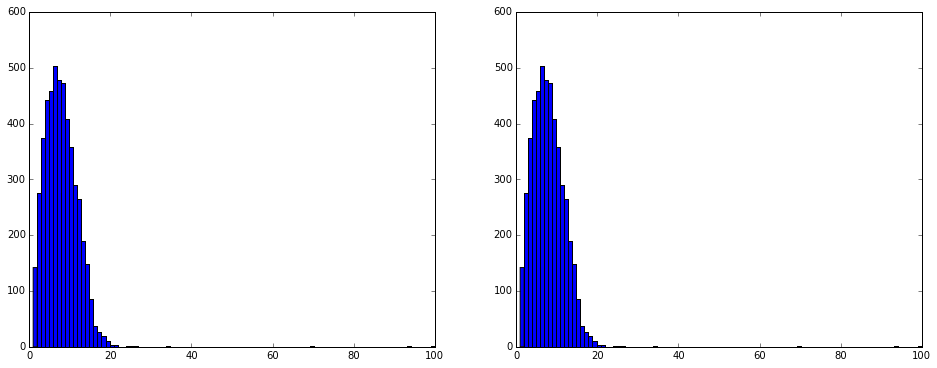

In [35]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.hist(mst.data, bins=mst.max())
ax = fig.add_subplot(1,2,2)
plt.hist(mst2.data, bins=mst2.max())

In [131]:
# inputs
n_clusters = 4
n_partitions = 100

In [132]:
# converting to diassociations
coassoc.data = coassoc.data.max() + 1 - coassoc.data

# get minimum spanning tree
mst = csgraph.minimum_spanning_tree(coassoc).astype(np.uint8)

# compute number of disconnected components
n_disconnect_clusters = mst.shape[0] - mst.nnz

# sort associations by weights
asort = mst.data.argsort()
sorted_weights = mst.data[asort]

if n_clusters == 0:
    # compute lifetimes
    lifetimes = sorted_weights[1:] - sorted_weights[:-1]

    # add 1 to n_partitions as the maximum weight because I also added
    # 1 when converting to diassoc to avoid having zero weights
    disconnect_lifetime = n_partitions + 1 - sorted_weights[-1]

    # maximum lifetime
    m_index = np.argmax(lifetimes)
    th = lifetimes[m_index]

    # get number of clusters from lifetimes
    indices = np.where(mst.data > mst.data[m_index])[0]
    if indices.size == 0:
        cont = 1
    else:
        cont = indices.size + 1

    #testing the situation when only 1 cluster is present
    # if maximum lifetime is smaller than 2 times the minimum
    # don't make any cuts (= 1 cluster)
    # max>2*min_interval -> nc=1
    close_to_zero_indices = np.where(np.isclose(lifetimes, 0))
    minimum = np.min(lifetimes[close_to_zero_indices])

    if th < 2 * minimum:
        cont = 1

    # add disconnected clusters to number of clusters if disconnected
    # lifetime is smaller
    if th > disconnect_lifetime:
        cont += n_disconnect_clusters
    else:
        cont = n_disconnect_clusters

    nc_stable = cont
else:
    nc_stable = n_clusters

  
    
n_comps, labels = csgraph.connected_components(mst)

4 [0 1 0 ..., 2 1 1]


(array([ 667.,  666.,  666.,    1.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ]),
 <a list of 4 Patch objects>)

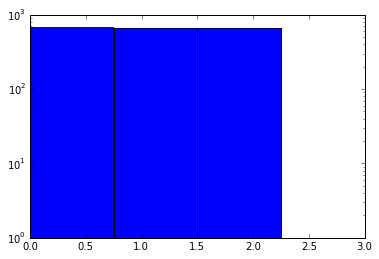

In [133]:
print n_comps, labels
plt.hist(labels, bins=n_comps, log=True)

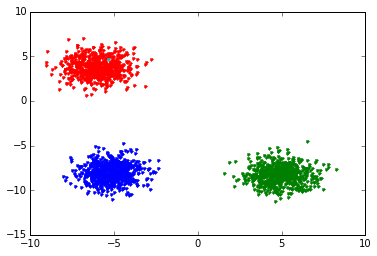

In [134]:
for c in xrange(n_comps):
    c_idx = labels == c
    plt.plot(data[c_idx,0],data[c_idx,1],'.')

In [33]:
nc_stable

3

In [66]:
nc_stable

2

In [ ]:
        if n_clusters == 0:
            # lifetime is here computed as the distance difference between 
            # any two consecutive nodes, i.e. the distance between passing
            # from n to n-1 clusters

            lifetimes = Z[1:,2] - Z[:-1,2]

            m_index = np.argmax(lifetimes)

            # Z is ordered in increasing order by weight of connection
            # the connection whose weight is higher than the one specified
            # by m_index MUST be the one from which the jump originated the
            # maximum lifetime; all connections above that (and including)
            # will be removed for the final clustering
            indices = np.where(Z[:,2] > Z[m_index, 2])[0]
            #indices = np.arange(m_index+1, Z.shape[0])
            if indices.size == 0:
                cont = 1
            else:
                cont = indices.size + 1

            # store maximum lifetime
            th = lifetimes[m_index]

            #testing the situation when only 1 cluster is present
            # if maximum lifetime is smaller than 2 times the minimum
            # don't make any cuts (= 1 cluster)
            #max>2*min_interval -> nc=1
            close_to_zero_indices = np.where(np.isclose(lifetimes, 0))
            minimum = np.min(lifetimes[close_to_zero_indices])

            if th < 2 * minimum:
                cont = 1

            nc_stable = cont

        else:
            nc_stable = n_clusters

        if nc_stable > 1:
            # only the labels are of interest

            labels = labels_from_Z(Z, n_clusters=nc_stable)

            # rename labels
            i=0
            for l in np.unique(labels):
                labels[labels == l] = i
                i += 1
        else:
            labels = np.zeros(self.n_samples, dtype = np.int32)

        self.labels_ = labels
        return labels

# linkage full

In [159]:
from scipy.cluster.hierarchy import linkage

In [204]:
coassoc = cfull.coassoc.copy()

In [207]:
myEac.make_diassoc_1d(coassoc, n_partitions)

# apply linkage
%time Z = myEac.linkage(coassoc, method="average")

CPU times: user 3.01 s, sys: 9.12 ms, total: 3.02 s
Wall time: 3.03 s


In [208]:
Z

array([[  3.10000000e+01,   2.06000000e+02,   1.00000000e+00,
          2.00000000e+00],
       [  2.31000000e+02,   9.47000000e+02,   1.00000000e+00,
          2.00000000e+00],
       [  2.55000000e+02,   1.66400000e+03,   1.00000000e+00,
          2.00000000e+00],
       ..., 
       [  3.98900000e+03,   3.99300000e+03,   9.96209231e+01,
          6.67000000e+02],
       [  3.99400000e+03,   3.99600000e+03,   1.01000000e+02,
          1.33400000e+03],
       [  3.99500000e+03,   3.99700000e+03,   1.01000000e+02,
          2.00000000e+03]])

In [185]:
labels = myEac.labels_from_Z(Z, n_clusters=100)
# rename labels
i=0
for l in np.unique(labels):
    labels[labels == l] = i
    i += 1

(array([ 35.,   0.,   0., ...,   0.,   0.,   2.]),
 array([   1.        ,    1.05002501,    1.10005003, ...,  100.89994997,
         100.94997499,  101.        ]),
 <a list of 1999 Patch objects>)

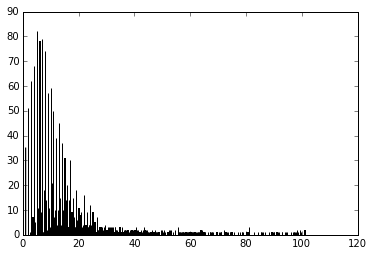

In [209]:
plt.hist(Z[:,2], bins=Z.shape[0])

[98 95 63 ..., 71 95 82]


(array([   1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    2.,    3.,    2.,
           3.,    3.,    2.,    2.,    2.,   12.,    2.,    2.,    4.,
           4.,    3.,    3.,    6.,    9.,    2.,    4.,    2.,   15.,
          20.,    7.,    3.,   41.,    3.,   15.,    3.,   17.,   25.,
          39.,    7.,   39.,   14.,   42.,   50.,    4.,    2.,    7.,
          51.,   45.,    7.,    5.,   14.,    7.,   49.,  260.,   51.,
          57.,   47.,   47.,   45.,    4.,  394.,   74.,    3.,  191.,  182.]),
 array([  0.  ,   0.99,   1.98,   2.97,   3.96,   4.95,   5.94,   6.93,
          7.92,   8.91,   9.9 ,  10.89,  11.88,  12.87,  13.86,  14.85,
         15.84,  16.83,  17.82,  18.81,  19.8 ,  20.79,  21.78,  2

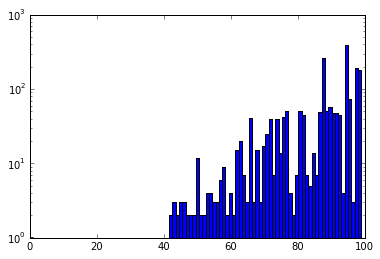

In [186]:
print labels
plt.hist(labels, bins=100, log=True)

# plot stuff

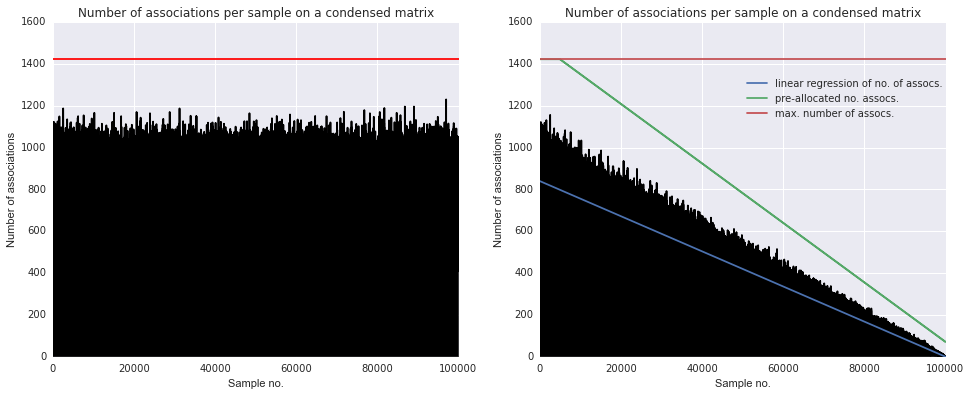

In [14]:
fig1 = plt.figure(figsize=(16,6))

ax = fig1.add_subplot(1,2,1)
x = np.arange(n_samples)
y = fullEAC.coassoc.degree[:-1]

x_max = [0, n_samples]
y_max = [fullEAC.sp_max_assocs, fullEAC.sp_max_assocs]

ax.plot(x, y, 'k', alpha=1)
ax.fill_between(x, 0, y, color='k', alpha=1)
ax.plot(x_max, y_max, 'r', label="max. number of assocs.")

ax.set_title("Number of associations per sample on a condensed matrix")
ax.set_xlabel("Sample no.")
ax.set_ylabel("Number of associations")
#ax.legend(loc=4)

################################################

ax = fig1.add_subplot(1,2,2)
x = np.arange(n_samples)
y = spEAC.coassoc.degree[:-1]

lin_indptr = myEacSp.indptr_linear(n_samples, fullEAC.sp_max_assocs,
                                   spEAC.coassoc.n_s, spEAC.coassoc.n_e,
                                   spEAC.coassoc.val_s, spEAC.coassoc.val_e)
y_lin = lin_indptr[1:] - lin_indptr[:-1]

fit = np.polyfit(x,y,1) # linear regression of degree
fit_fn = np.poly1d(fit)
y_reg = fit_fn(x)
y_reg = np.where(y_reg<0,0,y_reg)

ax.plot(x, y, color='k')
ax.fill_between(x, 0, y, color='k', alpha=1)
ax.plot(x, y_reg, label="linear regression of no. of assocs.")
ax.plot(x, y_lin, label="pre-allocated no. assocs.")
ax.plot(x_max, y_max, label="max. number of assocs.")

ax.set_title("Number of associations per sample on a condensed matrix")
ax.set_xlabel("Sample no.")
ax.set_ylabel("Number of associations")
ax.legend(loc=[0.5,0.7])

In [15]:
save_fig(fig1, "/home/chiroptera/eac_csr_cond_full_degree_100k")

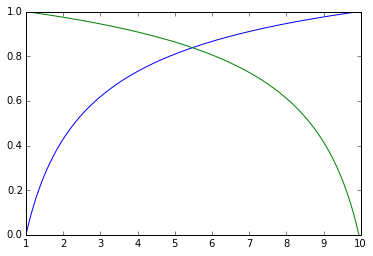

In [54]:
x = np.arange(1,10,0.05)
y = 1 / np.sqrt(x)
y = y.max() -y
y = y / y.max()
plt.plot(x,y)
plt.plot(x,y[::-1])
#plt.plot(x,np.sqrt(x)[::-1]/np.sqrt(x).max())

In [52]:
y.sum()

136.40980611903461

/home/chiroptera/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


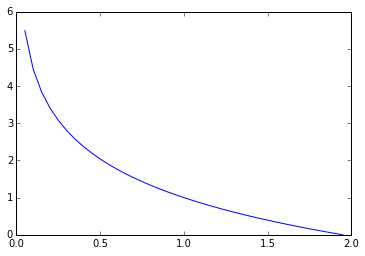

In [15]:
x = np.arange(0,2,0.05)
y = np.exp(x)
y /= y.max()
y = 1-y
plt.plot(x,y)

In [57]:
reload(myEacSp)

<module 'MyML.utils.sparse' from '/home/chiroptera/workspace/QCThesis/MyML/utils/sparse.pyc'>

In [60]:
y, y_sum = myEacSp.linear(n_samples, max_assocs, 0.1, 1, 1, 0.02)

In [61]:
total_area = n_samples * max_assocs
y_sum * 1.0 / total_area

0.55873891547049437

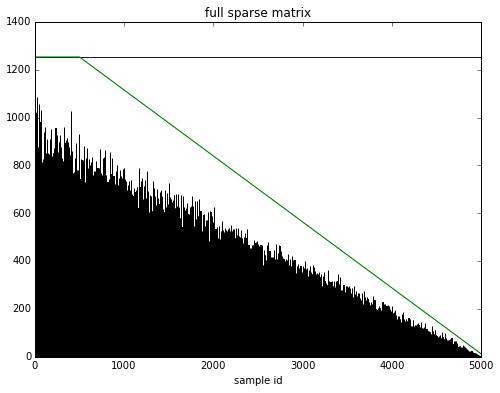

In [13]:
fig = plt.figure(figsize=(8,6))
x = np.arange(n_samples)
ax = fig.add_subplot(1,1,1)
ax.bar(x, csp.degree[:-1])
ax.plot([0,n_samples],[max_assocs, max_assocs])
#ax.plot(np.arange(n_samples), max_assoc_scheme)
ax.plot(x,y)

ax.set_title("full sparse matrix")
ax.set_xlabel("sample id")

In [67]:
import MyML.helper.scan as myScan
reload(myScan)

<module 'MyML.helper.scan' from '/home/chiroptera/workspace/QCThesis/MyML/helper/scan.py'>

In [63]:
y_c = y.copy()

In [71]:
y_sum

3503293

In [72]:
y_c

array([1254, 1254, 1254, ...,   25,   25, 5000], dtype=int32)

In [68]:
myScan.exprefixsumNumbaSingle(y)

3508293

In [77]:
class testme:
    def __init__(self,**kwargs):
        self.val2=kwargs.get("val2", 50)

In [80]:
a=testme(val2=100)
a.val2

100

In [73]:
y

array([      0,    1254,    2508, ..., 3503243, 3503268, 3503293], dtype=int32)

In [76]:
((y[1:] - y[:-1]) == y_c[:-1]).all()

True